In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Dropout,Flatten,LeakyReLU,BatchNormalization,Reshape,Embedding,Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [ ]:
def load_data():
    (X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
    X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1).astype('float32')
    X_train = (X_train - 127.5) / 127.5  # Normalize to [-1, 1]
    return X_train, y_train

In [ ]:
IMG_SIZE =28
LATENT_DIM=100
NUM_CLASS = 10
EPOCH =10
BATCH_SIZE = 64
NOISE_DIM = 100

In [ ]:
X_train,y_train = load_data()


In [ ]:
def build_generator():
    nosie_input=tf.keras.layers.Input(shape=(100,))
    lable_input=tf.keras.layers.Input(shape=(1,),dtype='int32')

    label_embedding=tf.keras.layers.Embedding(NUM_CLASS,(50))(lable_input)
    label_embedding=tf.keras.layers.Flatten()(label_embedding)

    model_input = tf.keras.layers.Concatenate()([nosie_input,label_embedding])

    x = layers.Dense(7*7*128, use_bias=False)(model_input)  # Reduced from 256
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((7, 7, 128))(x)

    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', activation='tanh')(x)

    return tf.keras.Model([nosie_input,lable_input],x)


In [ ]:
def build_discriminator():
  image_input=layers.Input(shape=(IMG_SIZE,IMG_SIZE,1))
  label_input=layers.Input(shape=(1,),dtype='int32')

  label_embedding=layers.Embedding(NUM_CLASS,28*28)(label_input)
  label_embedding=layers.Flatten()(label_embedding)
  label_embedding=layers.Reshape((28,28,1))(label_embedding)


  x = Concatenate()([image_input, label_embedding])

  x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(x)
  x = layers.LeakyReLU()(x)
  x = layers.Dropout(0.3)(x)

  x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)
  x = layers.Dropout(0.3)(x)


  x = layers.Flatten()(x)
  x = layers.Dense(128)(x)
  x = layers.LeakyReLU()(x)
  x = layers.Dropout(0.3)(x)

  x = layers.Dense(1, activation='sigmoid')(x)

  return tf.keras.Model([image_input, label_input], x)

In [ ]:
cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=False)

generator=build_generator()
discrimintor=build_discriminator()

generator_optimizer=tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)

In [ ]:
def train_step(images,labels):
  current_batch_size =tf.shape(images)[0]
  noise=tf.random.normal([current_batch_size,NOISE_DIM])
  generated_labels=tf.random.uniform([current_batch_size, 1], minval=0, maxval=NUM_CLASS, dtype=tf.int32)

  with tf.GradientTape()as gen_tape,tf.GradientTape() as disc_tape:
    generated_images=generator([noise,generated_labels],training=True)
    real_output=discrimintor([images,labels],training=True)
    fake_output=discrimintor([generated_images,generated_labels],training=True)

    disc_loss=cross_entropy(tf.ones_like(real_output),real_output)+cross_entropy(tf.zeros_like(fake_output),fake_output)
    gen_loss=cross_entropy(tf.ones_like(fake_output),fake_output)

  gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradient_of_discriminator = disc_tape.gradient(disc_loss, discrimintor.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradient_of_discriminator,discrimintor.trainable_variables))

  return gen_loss, disc_loss

In [ ]:
def generated_n_save_images(model,epoch,test_input):
  noise=tf.random.normal([16,NOISE_DIM])
  generated_label=tf.random.uniform([16,1],minval=0,maxval=NUM_CLASS,dtype='int32')
  predictions=model([noise,generated_label],training=False)
  fig=plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i,:,:,0]*127.5+127.5,cmap='gray')
    plt.title(f"Label: {generated_label[i].numpy()[0]}")
    plt.axis('off')
  plt.suptitle(f"Epoch {epoch}")
  plt.show()

In [ ]:
def train(dataset,epochs):
  for epoch in range(epochs):
    for image_batch,label_batch in dataset:
      gen_loss,disc_loss=train_step(image_batch,label_batch)
    print(f'Epoch {epoch+1},gen_loss{gen_loss},disc_loss={disc_loss}')

    if epoch%10==0:
      generated_n_save_images(generator,epoch,None)

In [ ]:
dataset=tf.data.Dataset.from_tensor_slices((X_train,y_train))
dataset=dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

Epoch 1,gen_loss8.699088096618652,disc_loss=0.004541660193353891


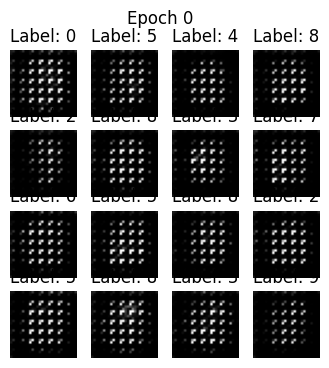

Epoch 2,gen_loss4.646875381469727,disc_loss=0.2511710524559021
Epoch 3,gen_loss3.941906213760376,disc_loss=0.42006969451904297
Epoch 4,gen_loss2.2287330627441406,disc_loss=0.5603216290473938
Epoch 5,gen_loss4.373372554779053,disc_loss=0.3218993544578552
Epoch 6,gen_loss2.203425168991089,disc_loss=0.544818639755249
Epoch 7,gen_loss3.4003336429595947,disc_loss=0.404580682516098
Epoch 8,gen_loss2.8613858222961426,disc_loss=1.092771291732788
Epoch 9,gen_loss3.313281297683716,disc_loss=1.185452938079834
Epoch 10,gen_loss1.828193187713623,disc_loss=0.947758138179779


In [ ]:
train(dataset,EPOCH)